<a href="https://colab.research.google.com/github/GabDada/Product-Marketing-Analytics/blob/main/%5BAB%20Testing%20for%20Fashion%20Retail%5DEmail_Sign_Up_for_Ecommerce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0 - Getting Started

**Business Problem**: Urban Wear is a cloting brand that's launching an ecommerce store. Currently, the pre-launched page is collecting emails from visitors. The plan is to collect as many emails for the website launch.

**Goal:**

As a Product Data Scientist, my goal is to design an, run and analyze an AB experiment that tests two versions of the email sign-up on the launch page.

**Test Groups:**

*Control Group*: The current sign up page with the Blue sign up button
*Teatment Group*: The new sign up page with an Green sign up button

*Business Outcome*: Help the prpduct team determine which version of the sign up page to use based on the AB test result.

In [ ]:
#@title Import Libraries

#Built-in Libraries
import random
import math

#Third-party libraries
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
from statsmodels.stats.power import TTestIndPower, tt_ind_solve_power
from statsmodels.stats.weightstats import ttest_ind
from statsmodels.stats.proportion import proportions_chisquare, confint_proportions_2indep

from google.colab import drive
drive.mount('/content/drive/')

#Disable Warnings
from warnings import filterwarnings
filterwarnings ('ignore')

#Set Seed for np random
SEED = 123
np.random.seed(SEED)

Mounted at /content/drive/


In [ ]:
#@title Load Data

#This notebook is run on Colab. Can also be run on Jupyter

# If using Colab, first Mount the Google Drive to this notebook. See libraries section above.
# Next, move the data files to a Google Drive location, and import them here as follows:

#Set data path and load data

data_path = '/content/drive/MyDrive/ABTestingCourse/Data/'
pretest = pd.read_csv(data_path+ 'pretest.csv'); print('pretest Data Imported')
test = pd.read_csv(data_path+'test.csv'); print('test Data Imported')

# Set date fields a date_time
pretest['date'] = pd.to_datetime(pretest['date'])
test['date'] = pd.to_datetime(test['date'])


pretest Data Imported
test Data Imported


# Step 1- Understanding the Business Problem

The first step in AB testing is to understand the business problem. We need to understand the data to do this. To understand the data, we need to carry out Exploratory data analysis. We will use built in libraries in Pandas to achieve that.

In exploratory data analysis, we examine the data tables to glean inherent insights.This done by observing summary statisitcs amongst other analysis

## Table Summary

In [ ]:
# Display the first five rows of the present table
pretest.head(5)

,visitor_id,date,email,experiment,group,submitted
0,1,2021-12-01,NaN,NaN,NaN,0
1,2,2021-12-01,NaN,NaN,NaN,0
2,3,2021-12-01,NaN,NaN,NaN,0
3,4,2021-12-01,NaN,NaN,NaN,0
4,5,2021-12-01,NaN,NaN,NaN,0


In [ ]:
#Summary statistics about the pretest table

#A. How many rows are there in the table
#B. What is the date range of the date field in the table?

print ('# of rows:', pretest.shape[0])
print('Date Range:', pretest.date.min(), '-', pretest.date.max())
print('Summary Stats:', pretest.describe())

# of rows: 309903
Date Range: 2021-12-01 00:00:00 - 2021-12-31 00:00:00
Summary Stats:           visitor_id         group      submitted
count  309903.000000  30039.000000  309903.000000
mean   154952.000000      0.501248       0.100983
std     89461.434574      0.500007       0.301307
min         1.000000      0.000000       0.000000
25%     77476.500000      0.000000       0.000000
50%    154952.000000      1.000000       0.000000
75%    232427.500000      1.000000       0.000000
max    309903.000000      1.000000       1.000000


In [ ]:
#Check for missing values. What is the null rate per column

pretest.isnull().mean()

visitor_id    0.000000
date          0.000000
email         0.899017
experiment    0.903070
group         0.903070
submitted     0.000000
dtype: float64

In [ ]:
#Get some stats about pretest performance

#A. How many visitors were there?
#B. How many sign-ups were there?
#C. What was the sign-up rate?

print('Total Visitor Count:', pretest.visitor_id.nunique())
print('Sign-Up Count:', pretest.submitted.sum())
print('Sign-up Rate:', pretest.submitted.mean().round(2))

Total Visitor Count: 309903
Sign-Up Count: 31295
Sign-up Rate: 0.1


## Plot Visitor per Day

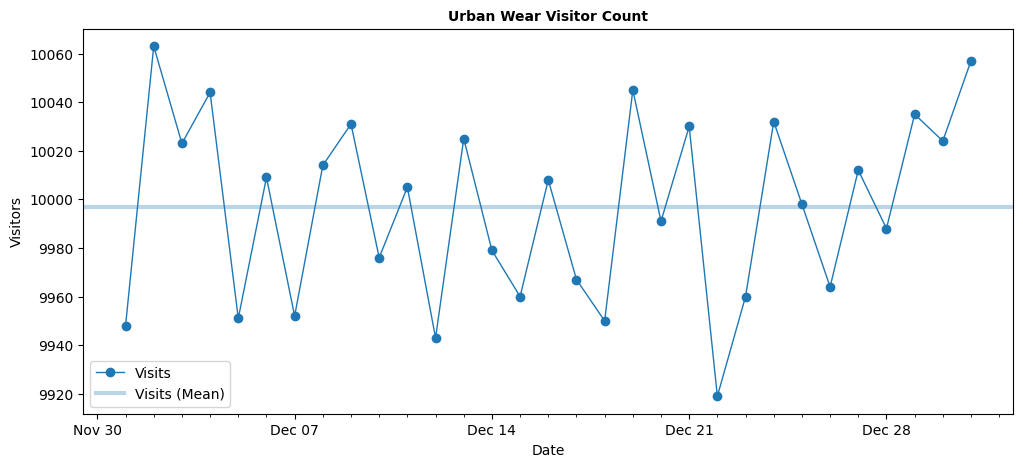

In [ ]:
# Set color palette for the plot
colors =sns.color_palette()
c1, c2 = colors[0], colors[1]

# Count sign-ups by date
visits_per_day = pretest.groupby('date')['submitted'].count()
visits_mean = visits_per_day.mean()

# Plot data
f, ax = plt.subplots(figsize = (12, 5))
plt.plot(visits_per_day.index, visits_per_day, '-o', color=c1, linewidth=1, label='Visits')
plt.axhline(visits_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Visits (Mean)')

# Format Plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Urban Wear Visitor Count', fontsize=10, weight='bold')
plt.ylabel('Visitors', fontsize=10)
plt.xlabel('Date', fontsize = 10)
plt.legend()

plt.show()


## Plot Sign-Up Rate per Day

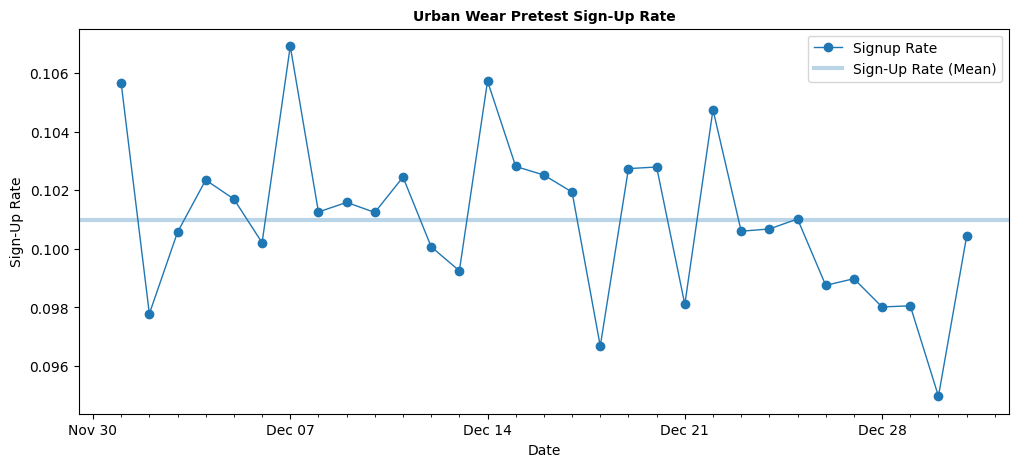

In [ ]:
# Get the sign-up rate per date
signup_rate_per_day = pretest.groupby('date')['submitted'].mean()
signup_rate_mean = signup_rate_per_day.mean()

# Plot data
f, ax = plt.subplots(figsize=(12, 5))
plt.plot(signup_rate_per_day.index, signup_rate_per_day, '-o', color=c1, linewidth=1, label='Signup Rate')
plt.axhline(signup_rate_mean, color=c1, linestyle='-', linewidth=3, alpha=0.3, label='Sign-Up Rate (Mean)')

# Format Plot
ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
ax.xaxis.set_minor_locator(mdates.DayLocator())
plt.title('Urban Wear Pretest Sign-Up Rate', fontsize=10, weight='bold')
plt.ylabel('Sign-Up Rate', fontsize=10)
plt.xlabel('Date', fontsize = 10)
plt.legend()

plt.show()

# Step 2- State the Hypothesis

The second step is to state the hypothesis. This followed by setting
parameters and values for our experiment. This include:
* Significance level (alpha)
* Statistical Power
* Minimum Detectable Effect (MDE)

1. Ho: The sign-up rates for the blue and green buttons are same
1. Ha: The sign-up rate for the blue and green buttons ar different

In [ ]:
# Experiment parametrs
alpha = 0.05 # Set the probability at 0.05. If the p-value is less than 0.05, we reject Ho
power = 0.80 # Ensure that there is 80% chance of detecting an effect with significance
mde = 1.10   # Detect a 20% improvement of the sign-up rate with statistical significance

#Proportions if the effect exists
p1 = 0.10          # Control (Blue)
p2 = p1 * (1+p1)   # Treatmnent (Green)

# Step 3- Design the Experiment

The third step is to design the experiment. This involves determinig the randomization unit, calculating the sample size and detrmining the experiment duration. We will explore how to:

* Calculate Sample Size
* Calculate experiment duration

### Calculate Sample Size

To detect an effect of 10.0% lift from the pretest sign-up at 10%, the sample size per group required is 15000.
The total sample size required in the experiment is 30000.


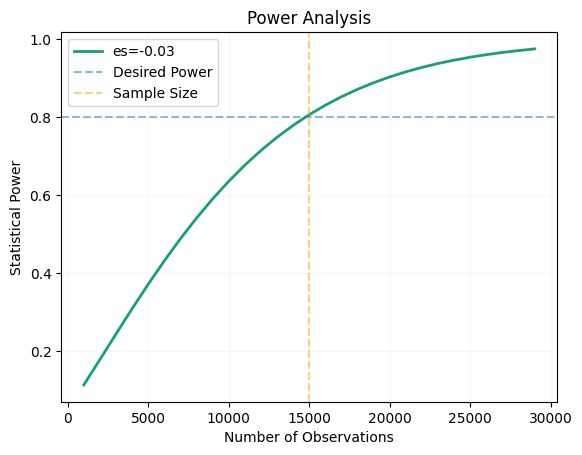

In [ ]:
# Calculate the effect size using COHEN's D
cohen_D = sm.stats.proportion_effectsize(p1, p2)

# Estimate the sample size required per group
n = tt_ind_solve_power(effect_size= cohen_D, power=power, alpha=alpha)
n = int(round(n, -3)) # Round up to the nearest thousand

print(f'To detect an effect of {100*(p2/p1-1):.1f}% lift from the pretest sign-up at {100*p1:.0f}%, '
      f'the sample size per group required is {n}.'
      f'\nThe total sample size required in the experiment is {2*n}.')

# Explore power across sample sizes
ttest_power = TTestIndPower()
ttest_power.plot_power(dep_var='nobs', nobs=np.arange(1000,30000,1000), effect_size=[cohen_D], title='Power Analysis')

# Set plot parameters

plt.axhline(0.8, linestyle = '--', label='Desired Power', alpha=0.5)
plt.axvline(n, linestyle='--', color='orange', label='Sample Size', alpha=0.5)
plt.ylabel('Statistical Power')
plt.grid(alpha=0.08)
plt.legend()
plt.show()

## Calculate Experiment Duration

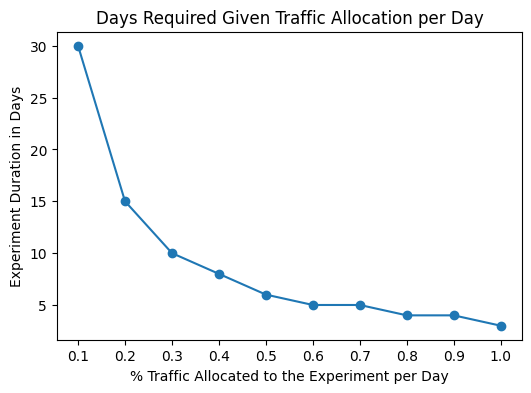

In [ ]:
# What's the duration required to achieve the required sample size given the
# percentage of unique visitors allocated to the experiment?

alloc = np.arange(0.10, 1.1, 0.10)
size = round(visits_mean, -3) * alloc
days = np.ceil(2*n / size)

# Generate Plot
f,ax = plt.subplots(figsize=(6,4))
ax.plot(alloc, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.set_title('Days Required Given Traffic Allocation per Day')
ax.set_ylabel('Experiment Duration in Days')
ax.set_xlabel('% Traffic Allocated to the Experiment per Day')
plt.show()

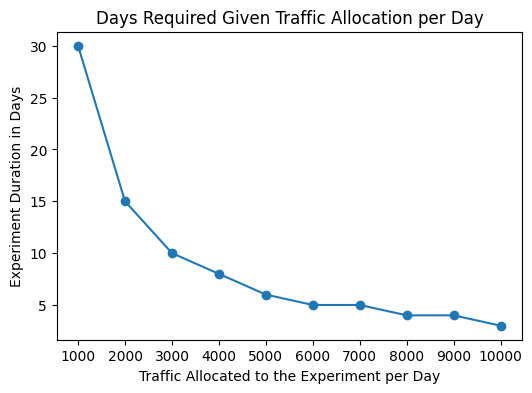

In [ ]:
# What's the duration required to achieve the required sample size given the
# number of unique visitors allocated to the experiment?

f,ax = plt.subplots(figsize=(6,4))
ax.plot(size, days, '-o')
ax.xaxis.set_major_locator(MultipleLocator(1000))
ax.set_title('Days Required Given Traffic Allocation per Day')
ax.set_ylabel('Experiment Duration in Days')
ax.set_xlabel('Traffic Allocated to the Experiment per Day')
plt.show()

In [ ]:
# Display the number of users required per day in an experiment given experiment duration.
print(f'For a 21-day experiment, {np.ceil(n * 2 / 21)} users are required per day') # Too long to wait
print(f'For a 14-day experiment, {np.ceil(n * 2 / 14)} users are required per day') # Sweet spot between risk and time
print(f'For a 7-day experiment, {np.ceil(n * 2 / 7)} users are required per day') # Too risky

For a 21-day experiment, 1429.0 users are required per day
For a 14-day experiment, 2143.0 users are required per day
For a 7-day experiment, 4286.0 users are required per day


#Step 4- Run the Experiment

We will take a look at the step that involves running an experiment. The code below a simplified version of how data is collected and analyzed in a large scale experiment platform.


In [ ]:
# Get the subset tables of control and treatment groups
AB_test = test[test.experiment == 'email_test'] #creates AB_test table from the main test table where experiment = 'email_test'
control_signups = AB_test[AB_test.group == 0]['submitted']
treatment_signups = AB_test[AB_test.group == 1]['submitted']

# Get Stats for both groups
AB_control_cnt = control_signups.sum()               #count control_signups group
AB_treatment_cnt = treatment_signups.sum()           #count treatment_signups group
AB_control_rate = control_signups.mean()             #Sign up rate for control group
AB_treatment_rate = treatment_signups.mean()         #Sign up rate for treatment group
AB_control_size = control_signups.count()            #control Sample Size
AB_treatment_size = treatment_signups.count()        #treatment Sample Size

# Show calculation
print(f'Control Sign-Up Rate: {AB_control_rate:.4}')
print(f'Treatment Sign-Up Rate: {AB_treatment_rate:.4}')



Control Sign-Up Rate: 0.09557
Treatment Sign-Up Rate: 0.1078


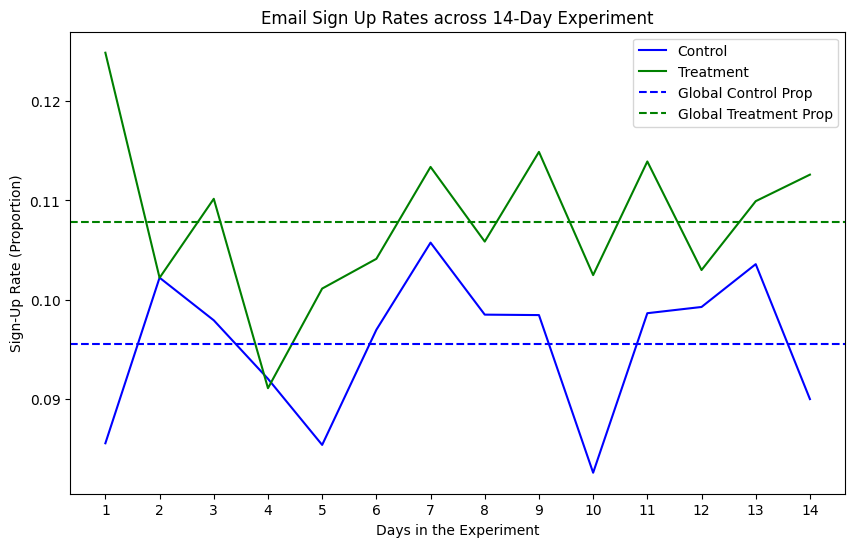

In [ ]:
# Calculate the sign-up rates per date
signups_per_day = AB_test.groupby(['group', 'date'])['submitted'].mean()
ctrl_props = signups_per_day.loc[0]
trt_props = signups_per_day.loc[1]

#Get the day range of experiment
exp_days = range(1, AB_test['date'].nunique() + 1) #possible error- Check to comfirm this email_test dataframe- Should be AB_test

# Let's display the sign-up rate per experiment day
f, ax = plt.subplots(figsize=(10, 6))
#General Plots
ax.plot(exp_days, ctrl_props, label = 'Control', color='b')
ax.plot(exp_days, trt_props, label='Treatment', color ='g')
ax.axhline(AB_control_rate, label='Global Control Prop', linestyle= '--', color='b' )
ax.axhline(AB_treatment_rate, label = 'Global Treatment Prop', linestyle='--', color='g')

# # Format Plot
ax.set_xticks(exp_days)
ax.set_title('Email Sign Up Rates across 14-Day Experiment')
ax.set_ylabel('Sign-Up Rate (Proportion)')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()

# Step 5- Access Validity Threats

We'll carry out two checks for Validity threats using two tests namely:
* AA Tests: To ensure there is no underlying difference btw control & treatment groups to begin with. NB: this should normally be done before AB test in real life scenarios.

* Sample Ration Mismatch (SRM): This is a chi-square goodness-of-fit test on group sizes to check for sample ratio mismatch. This is to ensure the randomization algorithm worked well.

Both these tests help to ensures that our AB test result is trustworthy and reduces risk of type 1 and type 2 errors

There are other tests that can be performed as well e.g segmentation analysis to perform novelty checks, etc.



## AA Test

In [ ]:
# Let's conduct an AA test

# Filter on visitors in the AA test
AA_test = pretest[pretest.experiment == 'AA_test']

# Grab the control and treatment groups in the AA test
AA_control = AA_test[AA_test.group == 0]['submitted']
AA_treatment = AA_test[AA_test.group == 1]['submitted']

# Get stats
AA_control_cnt = AA_control.sum()
AA_treatment_cnt = AA_treatment.sum()
AA_control_rate = AA_control.mean()
AA_treatment_rate = AA_treatment.mean()
AA_control_size = AA_control.count()
AA_treatment_size = AA_treatment.count()

# Show calculation
print('-------- AA Test ----------')
print(f'Control Sign-Up Rate: {AA_control_rate:.3}')
print(f'Treatment Sign-Up Rate: {AA_treatment_rate:.3}')

-------- AA Test ----------
Control Sign-Up Rate: 0.101
Treatment Sign-Up Rate: 0.0988


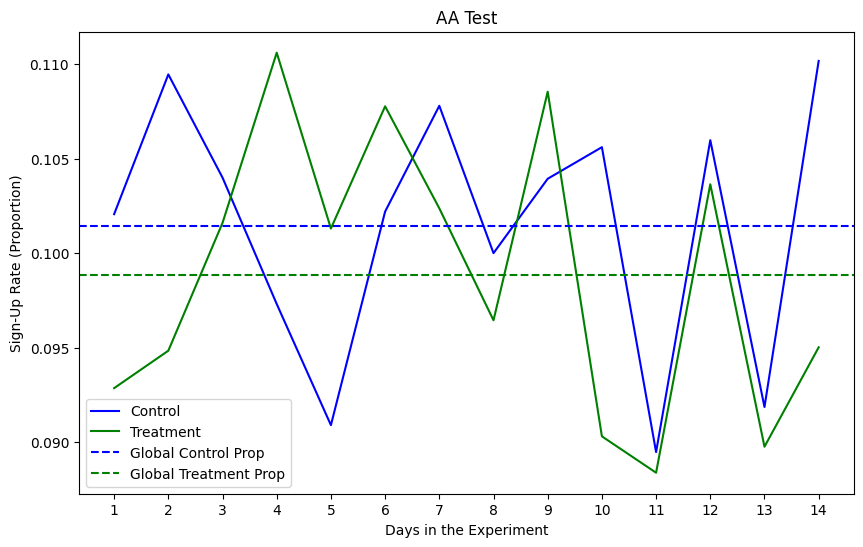

In [ ]:
# Sign-up rates per date
AA_signups_per_day = AA_test.groupby(['group','date'])['submitted'].mean()
AA_ctrl_props = AA_signups_per_day.loc[0]
AA_trt_props = AA_signups_per_day.loc[1]

# Get the day range of experiment
exp_days = range(1, AA_test['date'].nunique() + 1)

# Let's display the sign-up rate per experiment day
f, ax = plt.subplots(figsize=(10, 6))
# Generate plots
ax.plot(exp_days, AA_ctrl_props, label='Control', color='b')
ax.plot(exp_days, AA_trt_props, label='Treatment', color='g')
ax.axhline(AA_control_rate, label='Global Control Prop', linestyle='--', color='b')
ax.axhline(AA_treatment_rate, label='Global Treatment Prop', linestyle='--', color='g')

# # Format plot
ax.set_xticks(exp_days)
ax.set_title('AA Test')
ax.set_ylabel('Sign-Up Rate (Proportion)')
ax.set_xlabel('Days in the Experiment')
ax.legend()
plt.show()

In [ ]:
# Run a chi-square test

# Execute test
AA_chistats, AA_pvalue, AA_tab = proportions_chisquare([AA_control_cnt, AA_treatment_cnt], nobs=[AA_control_size, AA_treatment_size])

# Grab dates
first_date = AA_test['date'].min().date()
last_date = AA_test['date'].max().date()

# Set the ALPHA for the AA test
AA_ALPHA = 0.05

print(f'-------- AA Test ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between blue and green are the same.')
print('Ha: The sign-up rates between blue and green are different.\n')
print(f'Significance level: {AA_ALPHA}')

print(f'Chi-Square = {AA_chistats:.3f} | P-value = {AA_pvalue:.3f}')

print('\nConclusion:')
if AA_pvalue < AA_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference between the two groups. Check for instrumentation errors.')
else:
  print('Fail to reject Ho. Therefore, proceed with the AB test.')

-------- AA Test (2021-12-18 - 2021-12-31)---------

Ho: The sign-up rates between blue and green are the same.
Ha: The sign-up rates between blue and green are different.

Significance level: 0.05
Chi-Square = 0.577 | P-value = 0.448

Conclusion:
Fail to reject Ho. Therefore, proceed with the AB test.


## Sample Ratio Mismatch (SRM)



In [ ]:
# Let's check for sample ratio mismatch (SRM)

# Set test param
SRM_ALPHA = 0.05

# Get the observed and expected counts in the experiment
email_test = test[test.experiment == 'email_test']
observed = email_test.groupby('group')['experiment'].count().values
expected = [email_test.shape[0]*0.5]*2

# perform Chi-Square Goodness of Fit Test
chi_stats, pvalue = stats.chisquare(f_obs=observed, f_exp=expected)

print('------- A Chi-Square Test for SRM --------\n')
print('Ho: The ratio of samples is 1:1.')
print('Ha: The ratio of samples is not 1:1.\n')
print(f'Significance level: {SRM_ALPHA}')

print(f'Chi-Square = {chi_stats:.3f} | P-value = {pvalue:.3f}')

print('\nConclusion:')
if pvalue < SRM_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the ratio of samples not being 1:1. Therefore, there is SRM.')
else:
  print('Fail to reject Ho. Therefore, there is no SRM.')

------- A Chi-Square Test for SRM --------

Ho: The ratio of samples is 1:1.
Ha: The ratio of samples is not 1:1.

Significance level: 0.05
Chi-Square = 1.290 | P-value = 0.256

Conclusion:
Fail to reject Ho. Therefore, there is no SRM.


# Step 6- Conduct Statistical Inference on A/B Test

In this step we will walk through the procedure of applying statistical tests on the email sign-up AB test.

We will take a look at Chi-Squared and T-Test to evaluate the results from the experiment. Though, in real life, only one of the tests is sufficient, for learning, it's useful to compare and contrast the result from both.

We will end this step by looking at the confidence interval.

In [ ]:
# Set the ALPHA for the AB test
AB_ALPHA = 0.05

## Chi-Squared Test

In [ ]:
# Let's start with the chi-squared test

# Execute test
AB_chistats, AB_pvalue, AB_tab = proportions_chisquare([AB_control_cnt, AB_treatment_cnt], nobs=[AB_control_size, AB_treatment_size])

# Grab dates
first_date = AB_test['date'].min().date()
last_date = AB_test['date'].max().date()

# Run results
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between blue and green are the same.')
print('Ha: The sign-up rates between blue and green are different.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'Chi-Square = {AB_chistats:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.')
else:
  print('Fail to reject Ho.')

-------- AB Test Email Sign-Ups (2022-02-01 - 2022-02-14)---------

Ho: The sign-up rates between blue and green are the same.
Ha: The sign-up rates between blue and green are different.

Significance level: 0.05
Chi-Square = 12.312 | P-value = 0.000

Conclusion:
Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.


## T-Test for Proportions

In [ ]:
# Let's run T-Test for Proportions

# Execute test
AB_tstat, AB_pvalue, AB_df = ttest_ind(treatment_signups, control_signups)

# Grab dates
first_date = AB_test['date'].min().date()
last_date = AB_test['date'].max().date()

# Print results
print(f'-------- AB Test Email Sign-Ups ({first_date} - {last_date})---------\n')
print('Ho: The sign-up rates between blue and green are the same.')
print('Ha: The sign-up rates between blue and green are different.\n')
print(f'Significance level: {AB_ALPHA}')

print(f'T-Statistic = {AB_tstat:.3f} | P-value = {AB_pvalue:.3f}')

print('\nConclusion:')
if AB_pvalue < AB_ALPHA:
  print('Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.')
else:
  print('Fail to reject Ho.')

-------- AB Test Email Sign-Ups (2022-02-01 - 2022-02-14)---------

Ho: The sign-up rates between blue and green are the same.
Ha: The sign-up rates between blue and green are different.

Significance level: 0.05
T-Statistic = 3.509 | P-value = 0.000

Conclusion:
Reject Ho and conclude that there is statistical significance in the difference of sign-up rates between blue and green buttons.


## Final Results with Confidence Interval

In [ ]:
# Compute the Confidence Interval of the Test
ci = confint_proportions_2indep(AB_treatment_cnt, AB_treatment_size, AB_control_cnt, AB_control_size, method=None, compare='diff', alpha=0.05, correction=True)
lower = ci[0]
upper = ci[1]
lower_lift = ci[0] / AB_control_rate
upper_lift = ci[1] / AB_control_rate

In [ ]:
# Print results
print('--------- Sample Sizes ----------')
print(f'Control: {AB_control_size}')
print(f'Treatment: {AB_treatment_size}')

print('\n--------- Sign-Up Counts (Rates) ----------')
print(f'Control: {AB_control_cnt} ({AB_control_rate*100:.1f}%)')
print(f'Treatment: {AB_treatment_cnt} ({AB_treatment_rate*100:.1f}%)')

print('\n--------- Differences ----------')
print(f'Absolute: {AB_treatment_rate - AB_control_rate:.4f}') # ( Treatment Rate - Control Rate)
print(f'Relative (lift): {(AB_treatment_rate - AB_control_rate) / AB_control_rate*100:.1f}%') #[(Treatment Rate-Control Rate)/Control Rate]*100

print('\n--------- T-Stats ----------')
print(f'Test Statistic: {AB_tstat:3f}')
print(f'P-Value: {AB_pvalue:.5f}')

print('\n--------- Confidence Intervals ----------')
print(f'Absolute Difference CI: ({lower:.3f}, {upper:.3f})')
print(f'Relative Difference (lift) CI: ({lower_lift*100:.1f}%, {upper_lift*100:.1f}%)')

--------- Sample Sizes ----------
Control: 14942
Treatment: 15139

--------- Sign-Up Counts (Rates) ----------
Control: 1428 (9.6%)
Treatment: 1632 (10.8%)

--------- Differences ----------
Absolute: 0.0122
Relative (lift): 12.8%

--------- T-Stats ----------
Test Statistic: 3.509475
P-Value: 0.00045

--------- Confidence Intervals ----------
Absolute Difference CI: (0.005, 0.019)
Relative Difference (lift) CI: (5.7%, 19.9%)


# Step 7- Presentation of Results



In the email sign-up test for the Urban Wear pre-launch page, we aimed to improve the sign-up rate by changing the submit button color from blue to green.


We ran a two-week randomized controlled experiment (02/01/2022 - 02/14/2022) that enrolled a sample of users into the control (blue) and treatment (green) groups.


From the test we observed:
* An improvement of **12.8% lift** from the benchmark (blue) at 9.6%.

* The result was statistically significant with a 95% confidence interval between 5.7% and 19.9%.

>> **Decide to Launch or Not ?**

Given that we observed practical and statistical significance, our recommendation is to launch the new submit button in green.